# Simulation (ctobssim) 
## (Output saved on disk)

The purpose of this notebook is to perform a simulation using `ctobbsim` (and other scripts), create a count map with `ctskymap`, fit the spectrum with `cssens` and plot the spectrum using a function in the script `make_spectrum` (which comes together with ctools). 

In order to do the simulation, one has two options:
- create an *observation container* file with the [given notebook](observation_definition.ipynb), in which many different pointings can be specified and might be useful for some specific analysis;
- perform a simpler simulation, setting everything directly in this notebook.

In [1]:
import gammalib
import ctools
import cscripts 

# 1) Model Creation (TO BE DONE) - COPY FROM SIMULATION_MEM

We have to give a model for the source to be simulated: since many sources are simulated together, the xml model will have a piece for every source to simulate, including the background. An example model is $CTOOLS/share/models/crab.xml.

!xmllint $CTOOLS/share/models/crab.xml

# 2) Set up the simulation

The object sim in created and destroyed once the method execute() is called. If the observation definition file is provided, ctobssim will save a fits file for every pointing and a global *observation definition XML file*, different from the output of csobsdef (out_csobsdef.xml), which has a observation item for each pointing, in which the name of the fits file of the events is specified. 

## NOTE: choose just one of the following options.
#### The simulation can be set up in two main different ways: 

## - **WITH** *the observation definition XML* file (built with  [this](observation_definition.ipynb) notebook)...

### a) using the gammalib library

In [ ]:
obs_cont_bool = True

obs = gammalib.GObservations('out_csobsdef.xml')
obs.models(gammalib.GModels("${CTOOLS}/share/models/crab.xml"))
sim = ctools.ctobssim(obs)

src_name = obs[0].name()

#sim["prefix"] = src_name+"_obs_out_"                    # this is optional: "sim_events_" is the default

sim_out = src_name+"_obs_out.xml"
sim["outevents"] = sim_out
sim.execute()

### b) OR using only ctools

In [9]:
obs_cont_bool = True
src_name = "Crab"               # to be given by hand (SOLVE!!!!)

sim = ctools.ctobssim()
sim["inobs"] = "out_csobsdef.xml"
sim["inmodel"] = "crab.xml"   #we load a sample model

#sim["prefix"] = src_name+"_obs_out_"                    # this is optional: "sim_events_" is the default


sim_out = src_name+"_obs_out.xml"
sim["outevents"] = sim_out
sim.execute()

### ...and both in case a) and b) one can also see the resulting xml file, together with the fits files, one for each pointing. 

In [11]:
!ls  *_obs_out.xml sim_events_*.fits

Crab_obs_out.xml  sim_events_000001.fits  sim_events_000002.fits


## - WITHOUT the observation definition XML file,

(here we don'use csobsutils since it can only save the results in memory and not in disk, see the notebook realted to the simulation in memory for further details)

### 3)  using directly ctobssim.

In [ ]:
src_name = "Crab"
ra, dec = 83.6331, 22.0145
dur = 30                         # seconds
emin, emax = 0.05, 20.0          # in TeV
rad, deadc = 8.0, 0.95
caldb, irf = 'prod2','South_0.5h'

# name of the output of the simulation
sim_out = src_name+"_out_sim.fits"

In [ ]:
obs_cont_bool = False

sim = ctools.ctobssim()
sim["outevents"] = sim_out
sim["inmodel"] = "crab.xml"
sim["ra"] = ra
sim["dec"] = dec
sim["rad"] = rad
sim["tmin"] = 0.0
sim["tmax"] = dur
sim["emin"] = emin
sim["emax"] = emax
sim["caldb"] = caldb
sim["irf"] = irf
sim.execute()

### And the result is saved as fits file.

# 3) View the results
## 3.1) Create a count map with the tool ctskymap.

In [12]:
name_map_out = "skymap.fits"

skymap = ctools.ctskymap()
skymap['inobs'] = sim_out
skymap['emin'] = 0.1
skymap['emax'] = 100
skymap['nxpix'] = 20
skymap['nypix'] = 20
skymap['binsz'] = 0.5
skymap['coordsys'] = "CEL"
skymap['proj'] = "AIT"
skymap['xref'] = 83.63 #RA
skymap['yref'] = 22.01 #DEC
skymap['bkgsubtract'] = "NONE" 
skymap['outmap'] = name_map_out
skymap.execute()

and we view it with ds9:

In [13]:
!ds9 -wcs icrs -wcs skyformat degrees skymap.fits

Another option is to view it using matplotlib and the astropy library

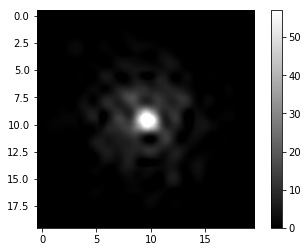

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits

hdu_list = fits.open(name_map_out)
image_data = hdu_list[0].data
plt.imshow(image_data, cmap='gray', interpolation = 'sinc')#, vmin=0)
plt.colorbar()
#plt.savefig("out.png")

# 4) Likelihood

In [ ]:
like = ctools.ctlike()
like['inobs'] = name+"_obs_out.xml"
like['inmodel'] = name+"_like_in.xml"
like['outmodel'] = name+"_like_out.xml"
like.execute()